In [1]:
#set up the imports
import vizdoom as vzd
import random
import time
import numpy as np

#import environment base class from OpenAI GYM
# from gym import Env
# from gym.spaces import Discrete, Box


from gymnasium import Env  # Change from gym to gymnasium
from gymnasium.spaces import Box, Discrete  # Import spaces from gymnasium
import cv2

from matplotlib import pyplot as plt




# import callback
import os
from stable_baselines3.common.callbacks import BaseCallback


# import ppo for training
from stable_baselines3 import PPO

#import evel policy
from stable_baselines3.common.evaluation import evaluate_policy


#import environment checker
from stable_baselines3.common import env_checker

In [32]:
#setup game
game = vzd.DoomGame()
game.load_config("github/ViZDoom-master/scenarios/basic.cfg")
game.init()
actions = np.identity(3, dtype=np.uint8)

In [33]:
game.close()

In [ ]:
#loop through episodes

episodes = 10
for episode in range(episodes):
    game.new_episode()
    #check the game is not finished
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        info = state.game_variables
        reward = game.make_action(random.choice(actions))
        print('reward:', reward)
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: 97.0
Result: -102.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: 99.0
Result: 66.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: 99.0
Result: 50.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4.0
reward: -9.0
reward: -4.0
reward: -4

ViZDoomUnexpectedExitException: Controlled ViZDoom instance exited unexpectedly.

In [2]:
# creating environment

class VizDoomGym(Env):

    def __init__(self, render=False):

        super().__init__()

        self.game = vzd.DoomGame()

        self.game.load_config("github/ViZDoom-master/scenarios/basic.cfg")


        if render == False:

            self.game.set_window_visible(False)

        else:

            self.game.set_window_visible(True)

        self.game.init()


        self.observation_space = Box(

            low=0, high=255, shape=(100, 160, 1), dtype=np.uint8
        )

        self.action_space = Discrete(3)
        

    def step(self, action):

        actions = np.identity(3, dtype=np.uint8)

        reward = self.game.make_action(actions[action], 4)


        if self.game.get_state():

            state = self.game.get_state().screen_buffer

            state = self.grayscale(state)

            ammo = self.game.get_state().game_variables[0]
            info = ammo

        else:

            state = np.zeros(self.observation_space.shape)

            info = 0


        info = {"info": info}
        terminated = self.game.is_episode_finished()
        truncated = False  # Set this to True if using a max step limit


        return state, reward, terminated, truncated, info


    def render(self):
        pass


    def reset(self, *, seed=None, options=None):
        self.game.new_episode()

        state = self.game.get_state().screen_buffer

        return self.grayscale(state), {}


    def grayscale(self, observation):

        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)

        resize = cv2.resize(gray, (160, 100), interpolation=cv2.INTER_CUBIC)

        state = np.reshape(resize, (100, 160, 1))

        return state


    def close(self):
        self.game.close()

In [3]:
env = VizDoomGym(render=True)

In [160]:
env.step(0)

(array([[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        ...,
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],
 
        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]], shape=(100, 160, 1)),
 99.0,
 True,
 0)

In [5]:
state= env.reset()

In [146]:
state.shape

(100, 160, 1)

In [4]:
env.close()

In [3]:
#import environment checker
from stable_baselines3.common import env_checker

In [50]:
env_checker.check_env(env)

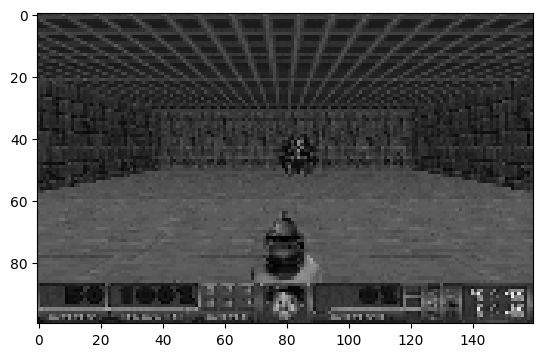

In [6]:
plt.imshow(cv2.cvtColor(state,cv2.COLOR_BGR2RGB))

# Callback and train

In [4]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(
                self.save_path, "best_model_{}".format(self.n_calls)
            )
            self.model.save(model_path)

        return True

In [5]:
CHECKPOING_DIR = "./train/train_basic"
LOG_DIR = "./logs/log_basic"

In [59]:
env = VizDoomGym()

In [61]:
env.close()

In [60]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOING_DIR)
model = PPO("CnnPolicy", env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001,n_steps=2048)
model.learn(total_timesteps=100000, callback=callback)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/log_basic\PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.4     |
|    ep_rew_mean     | -59      |
| time/              |          |
|    fps             | 39       |
|    iterations      | 1        |
|    time_elapsed    | 51       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 30.7         |
|    ep_rew_mean          | -68.5        |
| time/                   |              |
|    fps                  | 41           |
|    iterations           | 2            |
|    time_elapsed         | 98           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0028192452 |
|    clip_fractio

# Test Model

In [6]:
#import evel policy
from stable_baselines3.common.evaluation import evaluate_policy

In [7]:
#reload model from disk
model = PPO.load('./train/train_basic/best_model_100000')

In [8]:
env = VizDoomGym(render=True)

In [8]:
mean_reward, _ = evaluate_policy(model,env,n_eval_episodes=100)

d:\Faculta\Disertatie\venv\Lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [9]:
mean_reward

np.float64(87.24)

In [10]:
env.close()

In [9]:
# loop custom

for episode in range(15):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        time.sleep(0.1)
        total_reward += reward
    print("Total reward for episode {} is {}".format(total_reward, episode))
    time.sleep(2)

Total reward for episode 95.0 is 0
Total reward for episode 95.0 is 1
Total reward for episode 95.0 is 2
Total reward for episode 95.0 is 3
Total reward for episode 95.0 is 4
Total reward for episode 95.0 is 5


KeyboardInterrupt: 